### Naïve Bayes Project: Predicción de pérdida de clientes bancarios


# 1. Datasheet (Descripción del Conjunto de Datos)

El conjunto de datos representa la información de **1,924 clientes** de una compañía, con el objetivo de predecir si un cliente **abandonó (Exited = 1)** o **permaneció (Exited = 0)** en la empresa. Cada registro corresponde a un cliente único, con datos demográficos, financieros y de historial dentro de la empresa.

## Variables (Features y Target)

| Variable            | Descripción                                                                                          | Tipo         |
|---------------------|------------------------------------------------------------------------------------------------------|--------------|
| **CustomerId**       | Identificador único de cada cliente.                                                                | Numérico (ID) |
| **CreditScore**      | Puntuación de crédito del cliente (entre 0 y 1000).                                                   | Numérico     |
| **Geography**        | País de residencia del cliente (por ejemplo, Francia, Alemania, España).                             | Categórica   |
| **Gender**           | Género del cliente: `Male` o `Female` (posteriormente codificable como 1 = Male, 0 = Female).        | Categórica   |
| **Age**              | Edad del cliente en años.                                                                            | Numérico     |
| **Tenure**           | Antigüedad del cliente en la compañía (en años).                                                      | Numérico     |
| **Balance**          | Saldo actual en la cuenta bancaria del cliente.                                                       | Numérico     |
| **EstimatedSalary**  | Salario estimado anual del cliente.                                                                  | Numérico     |
| **Exited**           | Variable objetivo (Target), indica si el cliente dejó la compañía (1 = sí, 0 = no).                   | Binaria      |

## Objetivo

El objetivo es utilizar el algoritmo de **Naïve Bayes** para predecir si un cliente **abandonará o no** la compañía (variable objetivo `Exited`), a partir de sus características personales, financieras y de historial.

## Nota sobre el preprocesamiento

- La variable **Gender** se puede convertir a numérica:  
    - Male ➡️ 1  
    - Female ➡️ 0

- La variable **Geography** se puede codificar usando **One-Hot Encoding** o **Label Encoding**, según el algoritmo.
- Variables como **CustomerId** se pueden eliminar porque no aportan valor predictivo.


In [162]:
# Importamos las librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio
import itertools 

from plotly.offline import init_notebook_mode
init_notebook_mode(connected = True)

In [163]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics 

In [164]:
data = pd.read_csv('Churn_Modelling.csv')
print(f" shape: {data.shape}")
data.head()

 shape: (1924, 9)


,Customer ID,CreditScore,Geography,Gender,Age,Tenure,Balance,EstimatedSalary,Exited
0,15634602,619,France,Female,42.0,2,0.00,101348.88,1
1,15647311,608,Spain,Female,41.0,1,83807.86,112542.58,0
2,15619304,502,France,Female,42.0,8,159660.80,113931.57,1
3,15701354,699,France,Female,39.0,1,0.00,93826.63,0
4,15737888,850,Spain,Female,43.0,2,125510.82,79084.10,0


In [165]:
df = pd.DataFrame(data)
df

,Customer ID,CreditScore,Geography,Gender,Age,Tenure,Balance,EstimatedSalary,Exited
0,15634602,619,France,Female,42.0,2,0.00,101348.88,1
1,15647311,608,Spain,Female,41.0,1,83807.86,112542.58,0
2,15619304,502,France,Female,42.0,8,159660.80,113931.57,1
3,15701354,699,France,Female,39.0,1,0.00,93826.63,0
4,15737888,850,Spain,Female,43.0,2,125510.82,79084.10,0
...,...,...,...,...,...,...,...,...,...
1919,15739858,618,France,Male,56.0,7,0.00,142400.27,1
1920,15723720,591,France,Female,31.0,7,0.00,48778.46,0
1921,15638355,658,France,Female,35.0,5,126397.66,156361.58,1
1922,15805637,625,France,Male,36.0,9,108546.16,133807.77,1


In [166]:
df.isnull().sum().to_frame('NaN value')

,NaN value
Customer ID,0
CreditScore,0
Geography,1
Gender,0
Age,1
Tenure,0
Balance,0
EstimatedSalary,0
Exited,0


In [167]:
for col in df:
    print(f" {col}: {df[col].nunique()}")

 Customer ID: 1924
 CreditScore: 405
 Geography: 3
 Gender: 2
 Age: 66
 Tenure: 11
 Balance: 1241
 EstimatedSalary: 1924
 Exited: 2


In [168]:
df.describe(include = [np.number]).T

,count,mean,std,min,25%,50%,75%,max
Customer ID,1924.0,1.569092e+07,72301.500766,15565701.00,15628092.50,1.569068e+07,1.575210e+07,15815660.00
CreditScore,1924.0,6.500395e+02,99.081662,350.00,581.00,6.520000e+02,7.210000e+02,850.00
Age,1923.0,3.865836e+01,10.176423,18.00,32.00,3.700000e+01,4.300000e+01,82.00
Tenure,1924.0,5.094595e+00,2.862854,0.00,3.00,5.000000e+00,8.000000e+00,10.00
Balance,1924.0,7.720105e+04,62437.570993,0.00,0.00,9.749518e+04,1.282835e+05,214346.96
EstimatedSalary,1924.0,9.899815e+04,57323.065017,216.27,50115.05,9.813474e+04,1.469648e+05,199857.47
Exited,1924.0,2.063410e-01,0.404783,0.00,0.00,0.000000e+00,0.000000e+00,1.00


In [169]:
df.describe(include = [object]).T

,count,unique,top,freq
Geography,1923,3,France,925
Gender,1924,2,Male,1021


Aquí tienes una conclusión basada en los datos de la imagen:

El rango de edades de los clientes se encuentra entre 18 y 60 años.
* La variable objetivo (Exited) tiene dos clases: 0 y 1.
* La distribución de género está equilibrada, con un número similar de hombres y mujeres.
* Las características presentan escalas muy distintas, por lo que es recomendable aplicar una estandarización antes de entrenar un modelo.
* Las columnas "CustomerId" no aporta información relevante para el análisis y puede ser eliminada.

In [170]:
df.drop(columns=['Customer ID'], inplace=True)

In [171]:
df.drop(df.columns[[1]], axis=1, inplace=True)
df

,CreditScore,Gender,Age,Tenure,Balance,EstimatedSalary,Exited
0,619,Female,42.0,2,0.00,101348.88,1
1,608,Female,41.0,1,83807.86,112542.58,0
2,502,Female,42.0,8,159660.80,113931.57,1
3,699,Female,39.0,1,0.00,93826.63,0
4,850,Female,43.0,2,125510.82,79084.10,0
...,...,...,...,...,...,...,...
1919,618,Male,56.0,7,0.00,142400.27,1
1920,591,Female,31.0,7,0.00,48778.46,0
1921,658,Female,35.0,5,126397.66,156361.58,1
1922,625,Male,36.0,9,108546.16,133807.77,1


In [172]:
df['Gender'] = df['Gender'].replace(['Male','Female'], [0,1])
df

C:\Users\bryam\AppData\Local\Temp\ipykernel_9604\2480676073.py:1: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



,CreditScore,Gender,Age,Tenure,Balance,EstimatedSalary,Exited
0,619,1,42.0,2,0.00,101348.88,1
1,608,1,41.0,1,83807.86,112542.58,0
2,502,1,42.0,8,159660.80,113931.57,1
3,699,1,39.0,1,0.00,93826.63,0
4,850,1,43.0,2,125510.82,79084.10,0
...,...,...,...,...,...,...,...
1919,618,0,56.0,7,0.00,142400.27,1
1920,591,1,31.0,7,0.00,48778.46,0
1921,658,1,35.0,5,126397.66,156361.58,1
1922,625,0,36.0,9,108546.16,133807.77,1


In [172]:
df['Gender'] = df['Gender'].replace(['Male','Female'], [0,1])
df

C:\Users\bryam\AppData\Local\Temp\ipykernel_9604\2480676073.py:1: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



,CreditScore,Gender,Age,Tenure,Balance,EstimatedSalary,Exited
0,619,1,42.0,2,0.00,101348.88,1
1,608,1,41.0,1,83807.86,112542.58,0
2,502,1,42.0,8,159660.80,113931.57,1
3,699,1,39.0,1,0.00,93826.63,0
4,850,1,43.0,2,125510.82,79084.10,0
...,...,...,...,...,...,...,...
1919,618,0,56.0,7,0.00,142400.27,1
1920,591,1,31.0,7,0.00,48778.46,0
1921,658,1,35.0,5,126397.66,156361.58,1
1922,625,0,36.0,9,108546.16,133807.77,1


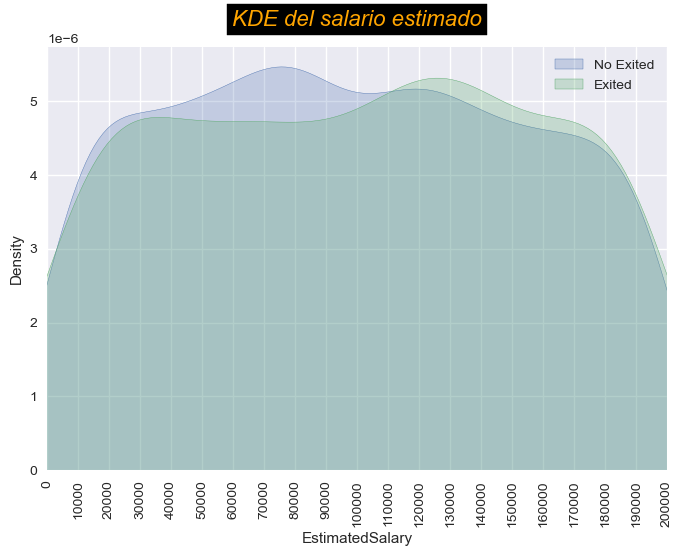

In [190]:
#Revisar La distribución del Salario estimado 
import warnings
warnings.filterwarnings("ignore",category = FutureWarning)

font = {'fontsize':16, 'fontstyle':'italic', 'backgroundcolor':'black','color':'orange'}
%matplotlib inline

plt.style.use('seaborn-v0_8')
sns.kdeplot(df.loc[df['Exited'] == 0, 'EstimatedSalary'], label='No Exited', fill= True)
sns.kdeplot(df.loc[df['Exited'] == 1, 'EstimatedSalary'], label='Exited', fill= True)
plt.title('KDE del salario estimado', fontdict=font, pad=15)
plt.xticks(np.arange(0,200001,10000), rotation=90)
plt.xlim([0,200001])
plt.legend()
plt.show()

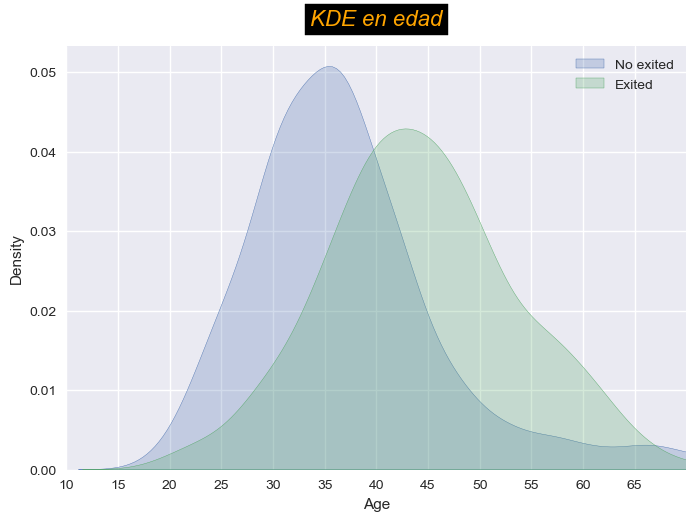

In [180]:
%matplotlib inline

plt.style.use('seaborn-v0_8')
sns.kdeplot(df.loc[df['Exited'] == 0, 'Age'], label='No exited', fill= True)
sns.kdeplot(df.loc[df['Exited'] == 1, 'Age'], label='Exited', fill= True)
plt.title('KDE en edad', fontdict=font, pad=15)
plt.xticks(np.arange(0,70,5))
plt.xlim([10,70])
plt.legend()
plt.show()

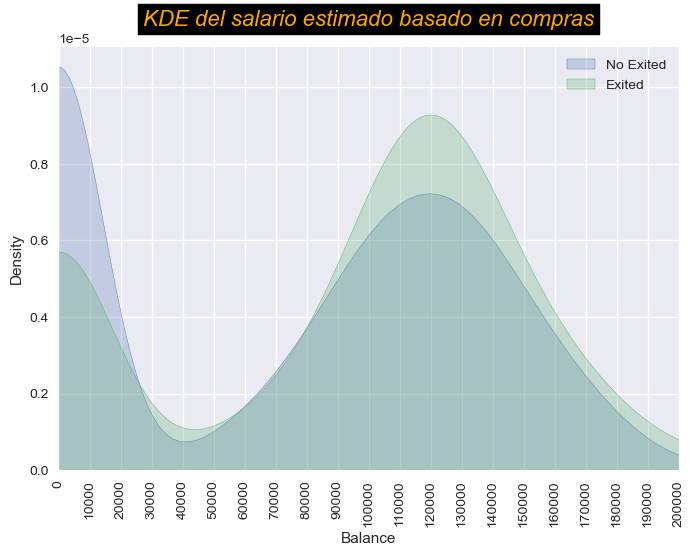

In [189]:
# Revisar la districución del salario estimado (basado en balance)
font  = {'fontsize' :16, 'fontstyle' :'italic', 'backgroundcolor' : 'black', 'color': 'orange'}
%matplotlib inline
plt.style.use('seaborn-v0_8')
sns.kdeplot(df.loc[df['Exited']==0, 'Balance'], label = 'No Exited', fill = True)
sns.kdeplot(df.loc[df['Exited']==1, 'Balance'], label = 'Exited', fill = True)
plt.title('KDE del salario estimado basado en balance', fontdict = font, pad = 15)
plt.xticks(np.arange(0,200001, 10000), rotation = 90)
plt.xlim([0, 200001])
plt.legend()
plt.show()

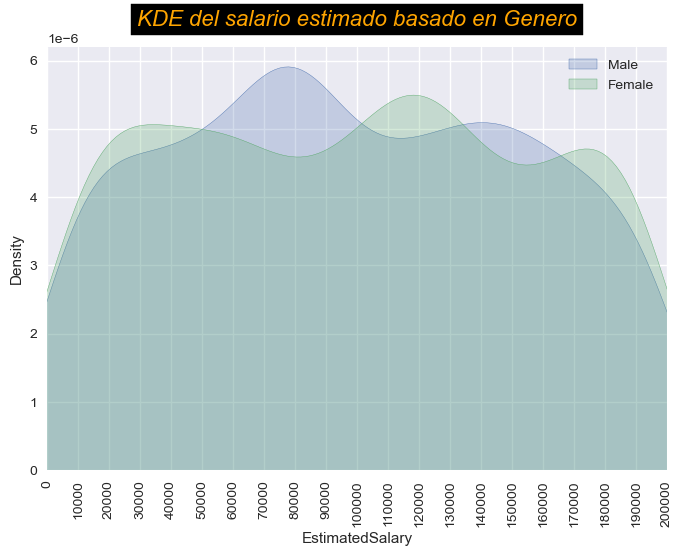

In [191]:
font  = {'fontsize' :16, 'fontstyle' :'italic', 'backgroundcolor' : 'black', 'color': 'orange'}
%matplotlib inline
plt.style.use('seaborn-v0_8')
sns.kdeplot(df.loc[df['Gender']==0, 'EstimatedSalary'], label = 'Male', fill = True)
sns.kdeplot(df.loc[df['Gender']==1, 'EstimatedSalary'], label = 'Female', fill = True)
plt.title('KDE del salario estimado basado en Genero', fontdict = font, pad = 15)
plt.xticks(np.arange(0,200001, 10000), rotation = 90)
plt.xlim([0, 200001])
plt.legend()
plt.show()

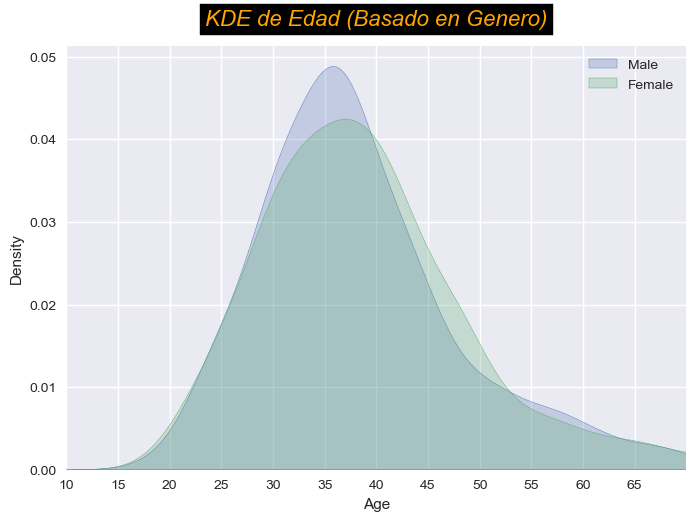

In [192]:
font  = {'fontsize' :16, 'fontstyle' :'italic', 'backgroundcolor' : 'black', 'color': 'orange'}
%matplotlib inline
plt.style.use('seaborn-v0_8')
sns.kdeplot(df.loc[df['Gender']==0, 'Age'], label = 'Male', fill = True)
sns.kdeplot(df.loc[df['Gender']==1, 'Age'], label = 'Female', fill = True)
plt.title('KDE de Edad (Basado en Genero)', fontdict = font, pad = 15)
plt.xticks(np.arange(0,70, 5))
plt.xlim([10, 70])
plt.legend()
plt.show()

### Distribución del Salario Estimado según Exited

* **Salario Estimado según Estado de Salida (Exited):** No hay diferencias significativas en la distribución del salario entre los que permanecen y los que abandonan la empresa, indicando que el salario no es un factor clave en la salida.

* **Edad según Estado de Salida (Exited):** Los clientes mayores tienen más probabilidades de abandonar la empresa, mientras que los más jóvenes tienden a quedarse, sugiriendo que la edad es relevante para predecir la salida.

* **Salario Estimado según Género:** No hay diferencias significativas en los salarios entre hombres y mujeres, lo que indica que el género no influye en el salario.

* **Edad según Género:** La distribución de edades es similar entre hombres y mujeres, sin una diferencia significativa.

### 4.1 Análisis univariable¶

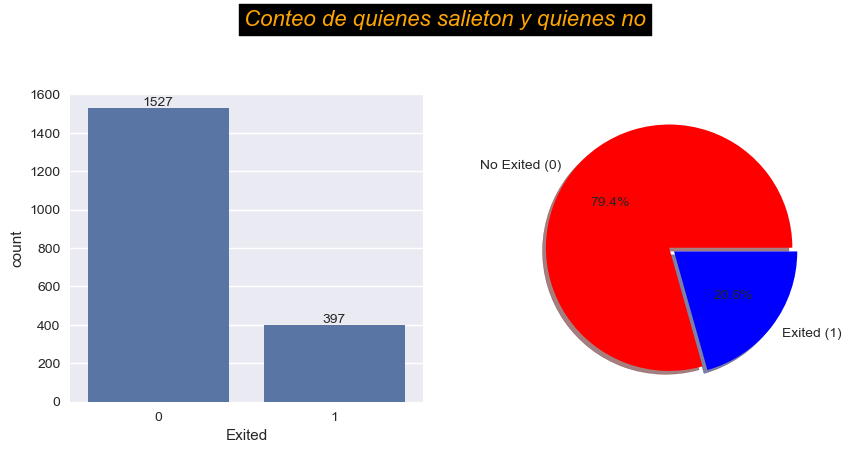

In [195]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(10,4))
sns.countplot(data=df, x='Exited', ax=axes[0])
for container in axes[0].containers:
    axes[0].bar_label(container)

slices = df.Exited.value_counts().values
activities = ['No Exited (0)', 'Exited (1)']
axes[1].pie(slices, labels=activities, colors=['red', 'blue'], shadow=True, explode=[0, 0.05], autopct='%1.1f%%')

plt.suptitle('Conteo de quienes salieton y quienes no', y=1.09, **font)
plt.show()


### 4.2 Analisis Bivariable


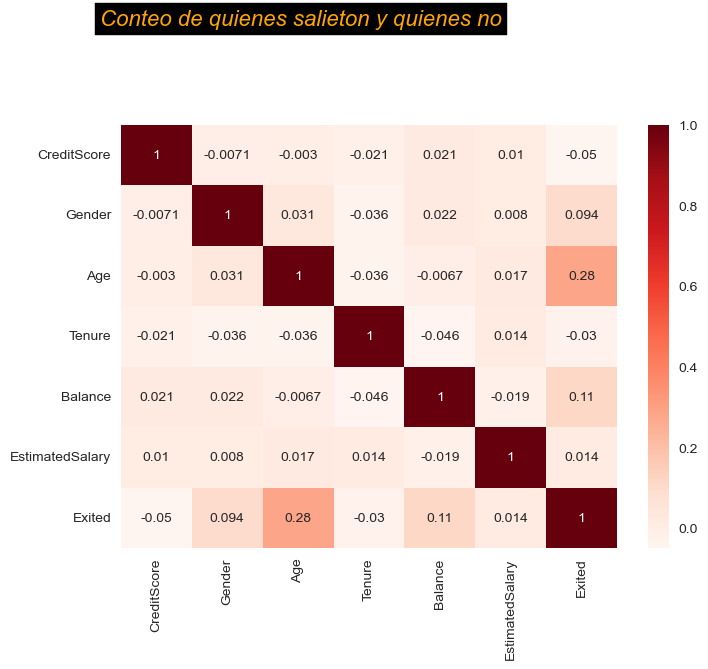

In [196]:
sns.heatmap(df.corr(), cmap='Reds', annot = True)
plt.suptitle('Conteo de quienes salieton y quienes no', y = 1.09, x= 0.35, **font)
plt.show()


### 4.2 Analisis Multiivariable

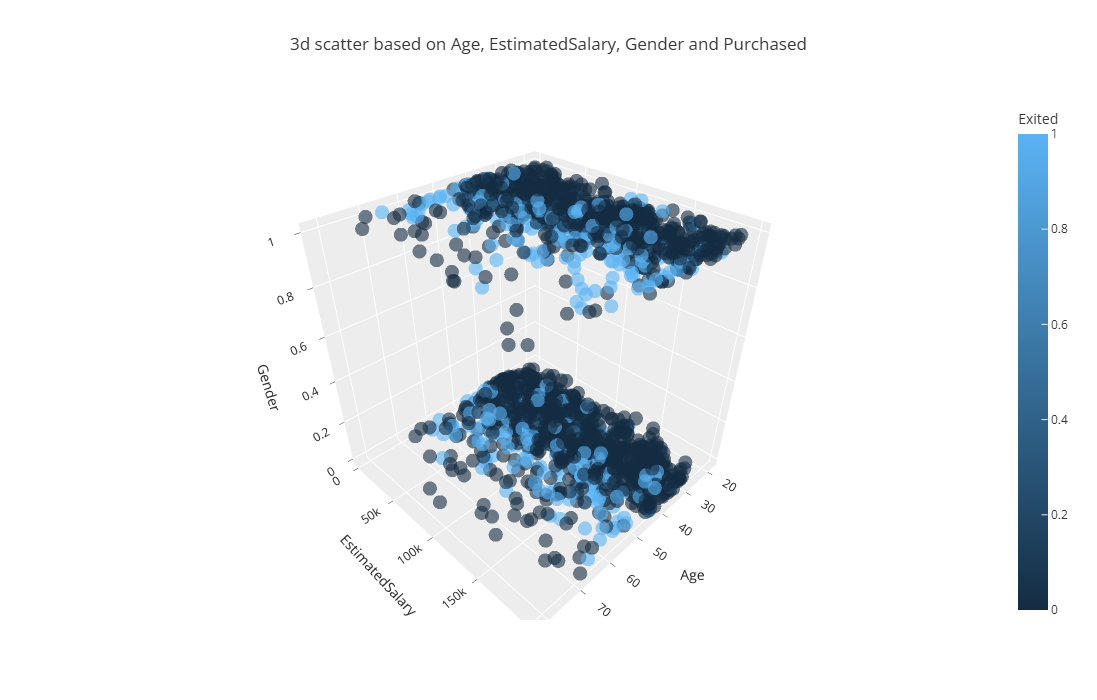

In [197]:
fig = px.scatter_3d(
    data_frame=df,
    x='Age',
    y='EstimatedSalary',
    z='Gender',
    color='Exited',
    template='ggplot2',
    opacity=0.6,
    height=700,
    title=f'3d scatter based on Age, EstimatedSalary, Gender and Purchased'
)
pio.show(fig)